<a href="https://colab.research.google.com/github/IzadoraSC/spectral_index/blob/main/Indices_Espectrais_v01_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ÍNDICES DE ESPECTRAIS
1. Obtenção dos dados (utilizando GEE):
  - Selecionar área de estudo;
  - Obtendo dados multiespectrais;
  - Índices espectrais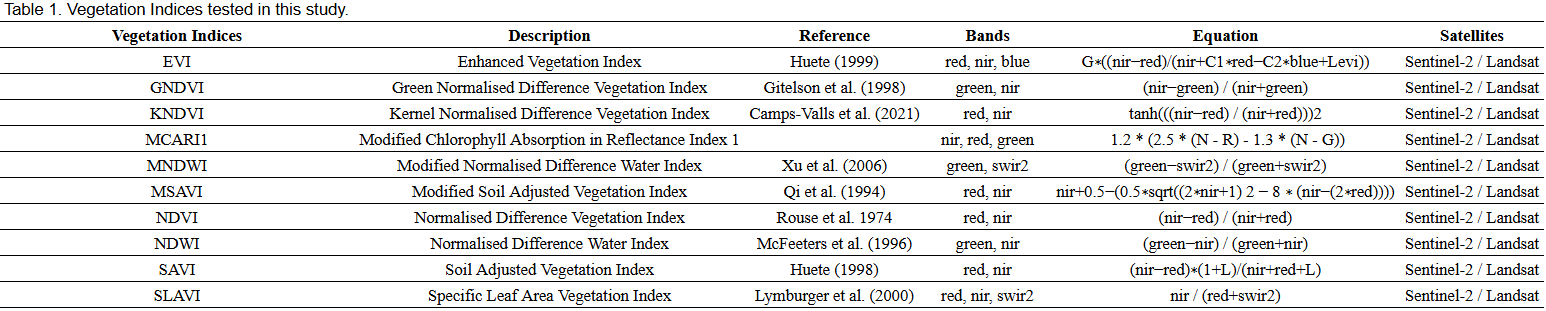
  - Temperatura de Superfície;
  - Exportação dos dados.

2. Extração de dados por ponto;
  
3. Análises: Correlação, PCA, etc.;

4. Referências.

Script By: Izadora S. de Carvalho.

Paper: Izadora S. de Carvalho, Swanni T. Alvarado, Patrick Costa Silva, Leo Leonel, Aline Silva, Tiago Massi Ferraz.

Obs: O código pode ser aplicado para outras áreas de estudos, estamos aberto a colaborações e sugestões.

Contato: izadoraflorestal@gmail.com / izadorasccs@gmail.com

Repositório para disponibilização e manutenção de código: Github IzadoraSC

##Conectando Drive

In [2]:
# Conectando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1   Obtendo dados do Google Earth Engine (GEE).
Obtendo as imagens/rasters que serão utilizados nas etapas de geração dos Índices Espectrais:
  - Dados Landsat
  - Dados Sentinel
---

### Instalando bibliotecas

In [3]:
# Instalando bibliotecas
!pip install spyndex -q
!pip install spectral -q
!pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.7/728.7 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 69.3 MB/s eta 0:00:00


### Importar as bibliotecas

In [4]:
#Importando bibliotecas

#GEE
import ee
import geemap

#Indices
import spyndex
import xarray as xr
import matplotlib.pyplot as plt
from rasterio import plot
import rasterio as rio
import pandas as pd
import seaborn as sns
import numpy as np
import dask.array as da


import spectral
import eemont
import geemap
import geemap.colormaps as cm


#Outras
import json
import geopandas as gpd
import os
#import geobr
import altair as alt ##biblioteca de visualização(gráficos)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Autenticação da conta do GEE

In [5]:
# Autenticação padrão da conta do GEE
ee.Authenticate()
ee.Initialize(project='ee-izadorasc')  ## 'project' é individual para cada usuário


### Usando geobr (para quando necessitar acessar base de dados do IBGE)

- Diversos arquivos vetoriais disponíveis

In [ ]:
# Lendo vetor do PNCM usando geobr

UCs = geobr.read_conservation_units()
UCs
#BR = geobr.read_country()
#BR
#BR.plot()

In [ ]:
# Selecionando área de interesse
list_of_names = ['PARQUE NACIONAL DA CHAPADA DAS MESAS']
pncm_df = UCs.query('name_conservation_unit in @list_of_names')
pncm_df

In [ ]:
MA = geobr.read_state(code_state='MA', year=2020)
MA

In [ ]:
MA.plot()

In [ ]:
pncm_df.plot()

In [ ]:
#Conversão de geodataframe para json
pncm_json = pncm_df.to_json()

#Carregando o arquivo
pncm_json_coords = json.loads(pncm_json)

# Selecionando coordenadas
pncm_coord = pncm_json_coords['features']

In [ ]:
print(pncm_json_coords)

In [ ]:
pncm_coord

In [ ]:
# Convertendo para FeatureCollection
aoi = ee.FeatureCollection(pncm_coord)

### **Data Image**

#### **Informações sobre os sensores e outras**

In [ ]:
# Reflectância de Superficíe

########### LANDSAT ##############

# Landsat 4 TM (Aug 22, 1982 - Jun 24, 1993)
  # USGS Landsat 4 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT04/C02/T1_L2"

# Landsat 5 TM (Mar 16, 1984 - May 05, 2012)
  # USGS Landsat 5 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT05/C02/T1_L2"

# Landsat 7 ETM+ (May 28, 1999 - Jul 15, 2023)
  # USGS Landsat 7 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LE07/C02/T1_L2"

# Landsat 8 OLI (Mar 18, 2013 - present)
  # USGS Landsat 8 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC08/C02/T1_L2"

# Landsat 9 OLI (Out 31, 2021 - present)
  # USGS Landsat 9 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC09/C02/T1_L2"

# scale factor = 2.75e-05
# scale factor surface temperature = 0.00341802

################## SENTINEL ########################

# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C (Jun 27, 2015 - present)
#Top-of-Atmosphere Reflectance
#ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED

# sensor = "COPERNICUS/S2_HARMONIZED"

# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (Mar 28, 2017 - present)
# Surface Reflectance
#ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
#https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

# sensor = "COPERNICUS/S2_SR_HARMONIZED"

##########################################
# Julian days
# jan = [1,31,'day_of_year'];
# fev = [32,59,'day_of_year'];
# mar = [60,90,'day_of_year'];
# abr = [91,120,'day_of_year'];
# may = [121,151,'day_of_year'];
# jun = [152,181,'day_of_year'];
# jul = [182,212,'day_of_year'];
# ago = [213,243,'day_of_year'];
# set = [244,273,'day_of_year'];
# out = [274,304,'day_of_year'];
# nov = [304,334,'day_of_year'];
# dez = [335,365,'day_of_year'];

############################################
# Alguns formatos de dados
# .toDouble()  #64-bit float
# .toFloat()  #32-bit float
# .toInt16()  # signed 16-bit integer
# .toInt32() # signed 32-bit integer
# .toUint16() # unsigned 16-bit integer

####Visualização dos dados:
  - Construindo paletas de cores.

In [6]:
#Visualização dos dados

#LANDSAT
VisLS457_falseColor = {
  'min': 0,
  'max': 0.3,
  'gamma': 1,
  'opacity': 1,
  'bands': ['SR_B5', 'SR_B4', 'SR_B3']}

VisLS89_falseColor = {
  'min': 0,
  'max': 0.3,
  'gamma': 1,
  'opacity': 1,
  'bands': ['SR_B6', 'SR_B5', 'SR_B4']}

VisLS89_trueColor = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1,
    'opacity': 1,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']}


#SENTINEL
VisS2 = {
  'min': 0.0,
  'max': 0.3,
  'gamma': 1.1,
  'bands': ['B4', 'B3', 'B2']}


# ÍNDICES

##Colors map
visNDVI = cm.palettes.ndvi
##Definindo os parâmetros
vis_NDVI = {
  'min': 0,
  'max': 1,
  'palette': visNDVI}

VisNDVI = {
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']
  }

##Definindo os parâmetros
VisNDWI = {
    'bands': ['NDWI'],
    'palette': ['#ece7f2', '#d0d1e6', ' #a6bddb', ' #74a9cf', ' #3690c0', ' #0570b0', ' #045a8d', '#023858'],
    'min': -0.7546916749172777,
    'max': -0.27315915803905233,
    'opacity': 1.0,
    'gamma': 1.0}

# '#ece7f2', '#d0d1e6', ' #a6bddb', ' #74a9cf', ' #3690c0', ' #0570b0', ' #045a8d', '#023858'
# VisNDWI = {
#   'min': 0,
#   'max': 1,
#   'palette': cm.palettes.ndwi}

# VisNDWI = {
#   'min': -1,
#   'max': 0.5,
#   'palette': ['red', 'yellow', 'green', 'blue']
#   }

#### **Máscara de Nuvens**
- Landsat - TM, OLI
- Sentinel 2 - MSI

In [7]:
## Landsat 4, 5, 7, 8 and 9 for SR data
def maskLSclouds(image):

  # Os bits 3 e 5 são a sombra da nuvem e a nuvem, respetivamente, para os produtos Landsat 4-5-7-8 e 9 SR
  # Aqui definimos os valores dos bits em valores de bytes.

# Criando uma função para mascarar pixéis de nuvens e sombras de nuvens
# 1 corresponde a céu limpo
# 3 corresponde a sombra de nuvem
# 5 corresponde a nuvem

  #cloudShadowBitMask = ee.Number(1).pow(3).int()
  #cloudsBitMask = ee.Number(1).pow(5).int()
  qaMask = image.select('QA_PIXEL').bitwise_and(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Obter a banda de pixel QA da coleção.
  #qa = image.select('QA_PIXEL')

  ###Fator de escala
  #opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

  ###Fator de escala
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  ##Produto resultante
  return image.addBands(opticalBands, None, True)\
  .addBands(thermalBands, None, True).updateMask(qaMask)\
  .updateMask(saturationMask)

  # Se esse processo não for realizado, não podemos filtrar por data depois.
  #return image.updateMask(mask.copyProperties(image,["system:time_start"]))

In [8]:
##Máscara de nuvens
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    #cloudBitMask = int(2**10)
    #cirrusBitMask = int(2**11)
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))

    # clouds is not clear
    # cloud = mask.Not().rename(['QA60'])

    # return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

#### **Área de estudo**

In [9]:
## Árae de estudo
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

ROI = ee.Geometry.Rectangle([-47.48, -6.85, -46.70, -7.42])
#ROI2 = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")
ROI = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")

Map.addLayer(ROI, {'color': 'black'}, 'Limite PNCM')

Map

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [10]:
## Pontos amostrais de campo
plotPoints = ee.FeatureCollection("projects/ee-izadorasc/assets/plots_1m")

Map.addLayer(plotPoints, {'color': 'red'}, 'Pontos amostrais')

#### **Definindo Sensor e Data**

In [12]:
#Definindo a coleção do sensor Landsat que será utilizado
#sensor = "LANDSAT/LT05/C02/T1_L2"
#sensor = "LANDSAT/LE07/C02/T1_L2"
#sensor = "LANDSAT/LC08/C02/T1_L2"  ## para dados de out/2022
sensor = "LANDSAT/LC09/C02/T1_L2"  ## para dados de julho/2022

#sensor = "COPERNICUS/S2_SR_HARMONIZED"

###Definição de entradas - Período de interesse
start_date = '2022-06-25'
end_date = '2022-07-13'
#sentinel
#start_date = '2022-07-05'
#end_date = '2022-07-07'

# start = '2022-10-01'
# end = '2022-10-31'
#date_range = ['2022-01-01', '2022-12-31']

#### **Imagens Landsat**

In [13]:
# imageLS = ee.ImageCollection(sensor).filterBounds(region)\
#                                       .filterDate(start, end)\
#                  .filter(ee.Filter.lt('CLOUD_COVER', 80))\
#                                                  .map(maskL8sr)\
#                                                  .select(['SR_B.*', 'ST_B.*'])

# imageLS

# Load Landsat surface reflectance data
LS_collection = ee.ImageCollection(sensor) \
    .filterBounds(ROI)\
    .filter(ee.Filter.lt('CLOUD_COVER', 30))\
    .filterDate(start_date, end_date)

# Map the maskLSclouds function over each seasonal dataset and take the median of clear pixels.
img_comp = LS_collection.map(maskLSclouds).median()

# Clip the composite images to the Region of Interest
clip_ls_comp = img_comp.clip(ROI)

# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

# Add the wet and dry season composites to the map

# LS4 LS5 and LS7
# Map.addLayer(clip_wet_comp, paletteVisLS457, 'Wet_composite')
# Map.addLayer(clip_dry_comp, paletteVisLS457, 'Dry_composite')

# LS8 and LS9
Map.addLayer(clip_ls_comp, VisLS89_falseColor, 'LS - Falsa Cor')
Map.addLayer(clip_ls_comp, VisLS89_trueColor, 'LS - Cor Verdadeira')
# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [14]:
#Verificando cenas da coleção
LS_collection

In [15]:
## Verificando as bandas
bandas = clip_ls_comp.bandNames()
bandas

In [16]:
## Banda termal
imageTermal = clip_ls_comp.select(['ST_B.*']) #selecionando somente a banda do termal
#imageTermal

## Verificando a banda
bandaTermal = imageTermal.bandNames()
bandaTermal

In [17]:
## Visualizando banda termal
Map.addLayer(imageTermal, {'bands': ['ST_B10'], 'min': 303.85, 'max': 321.47, 'palette' : ['blue', 'green', 'yellow', 'red']}, 'Termal')
Map

Map(bottom=136581.0, center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], …

#### **Sentinel 2**

In [ ]:
##Selecionar imagens da coleção
S2_collection = ee.ImageCollection(sensor)\
                              .filterBounds(ROI)\
                              .filter(ee.Filter.date(start_date, end_date))\
                              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))

# Map the maskLSclouds function over each seasonal dataset and take the median of clear pixels.
imgS2_comp = S2_collection.map(maskS2clouds).median()

# Clip the composite images to the Region of Interest
clip_s2_comp = imgS2_comp.clip(ROI)

# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

# Add the wet and dry season composites to the map

# LS4 LS5 and LS7
# Map.addLayer(clip_wet_comp, paletteVisLS457, 'Wet_composite')
# Map.addLayer(clip_dry_comp, paletteVisLS457, 'Dry_composite')

# LS8 and LS9
Map.addLayer(clip_s2_comp, VisS2, 'S2')

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
S2_collection

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


In [ ]:
## Verificando as bandas
bandas_S2 = clip_s2_comp.bandNames()
bandas_S2

#####Download

In [ ]:
#region= ROI.getInfo()["coordinates"]
task = ee.batch.Export.image.toDrive(
            image= clip_s2_comp.select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
                                       'B11', 'B12'),
            description= "s2_PNCM_06072022",
            folder= "00_vegetation_data",
            region=ROI.geometry(), # conversão necessária para recortar o raster de saída
            scale= 10, ## tamanho do pixel em metros
            crs= "EPSG:4326", #WGS84 - World Geodetic System 1984
            fileFormat= "GeoTIFF",
            maxPixels= 5000000000) # Definir um valor muito grande para garantir que toda a imagem seja exportada

task.start()

### **Índices Espectrais**

In [ ]:
# Open a dataset (in this case a xarray.DataArray)
snt = ("/content/drive/MyDrive/00_vegetation_data/s2_PNCM_06072022.tif")
snt

'/content/drive/MyDrive/00_vegetation_data/s2_PNCM_06072022.tif'

In [ ]:
clip_s2_comp.getInfo()
img = clip_s2_comp


In [ ]:
idx = spyndex.computeIndex(
    index = ["VARI","ExG","NDVI"],
    params = {
        "R": img["R"],
        "G": img["G"],
        "B": img["B"],
        "N": img["N"]
    }
)

In [ ]:
print(f"idx type: {type(idx)}")

idx type: <class 'ee.image.Image'>


In [ ]:
idx

In [ ]:
img = img.addBands(idx)
img

In [ ]:
img.bandNames().getInfo()

EEException: Image.select: Band pattern 'R' did not match any bands. Available bands: [B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, AOT, WVP, SCL, TCI_R, TCI_G, TCI_B, MSK_CLDPRB, MSK_SNWPRB, QA10, QA20, QA60]

In [ ]:

with rio.open(snt) as src:
    # Read the image data as a NumPy array
    data = src.read()

    # Get the image metadata
    meta = src.meta

    # Create a DataFrame from the image data
    df = pd.DataFrame(data.transpose((1, 2, 0)), columns=meta['bands'])

    # Set the DataFrame's index and columns to the image coordinates
    df.index = range(meta['height'])
    df.columns = range(meta['width'])

# Print the DataFrame
print(df)

KeyError: 'band_names'

In [ ]:
# prompt: tem como ler o tif como um dataframe?

import rasterio
import pandas as pd

with rasterio.open(snt) as src:
    # Read the image data as a NumPy array
    data = src.read()

    # Get the image metadata
    meta = src.meta

    # Create a DataFrame from the image data
    df = pd.DataFrame(data.transpose((1, 2, 0)), columns=meta['band_names'])

    # Set the DataFrame's index and columns to the image coordinates
    df.index = range(meta['height'])
    df.columns = range(meta['width'])

# Print the DataFrame
print(df)


In [ ]:
# ler o tif como um array?

with rio.open(snt) as src:
    # Read the image data as a NumPy array
    data = src.read()

    # Get the image metadata
    meta = src.meta

    profile = src.profile

    # Create a DataFrame from the image data
    # df = pd.DataFrame(data.transpose((1, 2, 0)), columns=meta['bands'])



In [ ]:
import ee, eemont, geemap

In [ ]:
clip_s2_comp

In [ ]:
gdf = geemap.ee_to_gdf(clip_s2_comp, 'bands')
gdf

TypeError: ee_object must be an ee.FeatureCollection

In [ ]:
# Transpose the array
tp_array = np.transpose(array, (1, 2, 0))

# Print the shape of the transposed array
print(tp_array.shape)


(5258, 7545, 10)


In [ ]:
X = tp_array[:,:,:]
Y = tp_array[:,:,-1]

In [ ]:
X = np.nan_to_num(X)
Y = np.nan_to_num(Y)

In [ ]:
flatten_X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])

In [ ]:
flatten_Y = Y.flatten()

In [ ]:
flatten_X.shape

(39671610, 10)

In [ ]:
flatten_X = np.delete(flatten_X, np.where(flatten_Y == 0), axis = 0)

In [ ]:
flatten_Y = np.delete(flatten_Y, np.where(flatten_Y == 0))

In [ ]:
np.unique(flatten_Y)

array([0.0093, 0.0099, 0.0108, ..., 0.6267, 0.6366, 0.6803], dtype=float32)

In [ ]:
flatten_X.shape

(16246867, 10)

In [ ]:
flatten_Y.shape

(16246867,)

In [ ]:
# All indices
spyndex.indices

SpectralIndices(['AFRI1600', 'AFRI2100', 'ANDWI', 'ARI', 'ARI2', 'ARVI', 'ATSAVI', 'AVI', 'AWEInsh', 'AWEIsh', 'BAI', 'BAIM', 'BAIS2', 'BCC', 'BI', 'BITM', 'BIXS', 'BLFEI', 'BNDVI', 'BRBA', 'BWDRVI', 'BaI', 'CCI', 'CIG', 'CIRE', 'CSI', 'CSIT', 'CVI', 'DBI', 'DBSI', 'DPDD', 'DSI', 'DSWI1', 'DSWI2', 'DSWI3', 'DSWI4', 'DSWI5', 'DVI', 'DVIplus', 'DpRVIHH', 'DpRVIVV', 'EBBI', 'EBI', 'EMBI', 'ENDVI', 'EVI', 'EVI2', 'EVIv', 'ExG', 'ExGR', 'ExR', 'FAI', 'FCVI', 'GARI', 'GBNDVI', 'GCC', 'GDVI', 'GEMI', 'GLI', 'GM1', 'GM2', 'GNDVI', 'GOSAVI', 'GRNDVI', 'GRVI', 'GSAVI', 'GVMI', 'IAVI', 'IBI', 'IKAW', 'IPVI', 'IRECI', 'LSWI', 'MBI', 'MBWI', 'MCARI', 'MCARI1', 'MCARI2', 'MCARI705', 'MCARIOSAVI', 'MCARIOSAVI705', 'MGRVI', 'MIRBI', 'MLSWI26', 'MLSWI27', 'MNDVI', 'MNDWI', 'MNLI', 'MRBVI', 'MSAVI', 'MSI', 'MSR', 'MSR705', 'MTCI', 'MTVI1', 'MTVI2', 'MuWIR', 'NBAI', 'NBLI', 'NBLIOLI', 'NBR', 'NBR2', 'NBRSWIR', 'NBRT1', 'NBRT2', 'NBRT3', 'NBRplus', 'NBSIMS', 'NBUI', 'ND705', 'NDBI', 'NDBaI', 'NDCI', 'NDDI

In [ ]:
# Index

# spyndex.indices.EVI
# spyndex.indices.GNDVI
spyndex.indices.kNDVI
# spyndex.indices.MCARI1
# spyndex.indices.MNDWI
# spyndex.indices.MSAVI
# spyndex.indices.NDVI
# spyndex.indices.NDWI
# spyndex.indices.SAVI
# spyndex.indices.SLAVI

SpectralIndex(kNDVI: Kernel Normalized Difference Vegetation Index)
        * Application Domain: kernel
        * Bands/Parameters: ['kNN', 'kNR']
        * Formula: (kNN-kNR)/(kNN+kNR)
        * Reference: https://doi.org/10.1126/sciadv.abc7447
        

In [ ]:
# spyndex.constants.L
spyndex.constants.C1
# spyndex.constants.C2
# spyndex.constants.g

Constant(C1: Coefficient 1 for the aerosol resistance term)
        * Default value: 6.0
        

In [ ]:
# Compute the desired spectral indices
#Sentinel-2
idx = spyndex.computeIndex(
    index = ["EVI", "GNDVI", "MCARI1", "MNDWI", "MSAVI",
             "NDVI", "NDWI", "SAVI", "SLAVI"],
    params = {
        "B": tp_array[:,:, 0],  # Assuming B2 is the third band (index 2)
        "G": tp_array[:,:, 1],  # Assuming B3 is the fourth band (index 3)
        "R": tp_array[:,:, 2],  # Assuming B4 is the fifth band (index 4)
        "N": tp_array[:,:, 6],  # Assuming B8 is the ninth band (index 8)
        "RE1": tp_array[:,:, 3], # Assuming B5 is the sixth band (index 5)
        "RE2": tp_array[:,:, 6], # Assuming B6 is the seventh band (index 6)
        "S1": tp_array[:,:, 8], # Assuming B11 is the twelvth band (index 11)
        "S2": tp_array[:,:, 9], # Assuming B12 is the thirteenth band (index 12)
        "g": 2.5,
        "C1": 6,
        "C2": 7.5,
        "L": 0.5
   }
)

In [ ]:
# Compute the desired spectral indices DEU CERTO  A PARIR DAQUI

#Sentinel-2
idx = spyndex.computeIndex(
    index = ["EVI", "GNDVI", "MCARI1", "MNDWI", "MSAVI",
             "NDVI", "NDWI", "SAVI", "SLAVI"],
    params = {
        "B": clip_s2_comp.select('B2'),
        "G": clip_s2_comp.select('B3'),
        "R": clip_s2_comp.select('B4'),
        "N": clip_s2_comp.select('B8'),
        "RE1": clip_s2_comp.select("B5"),
        "RE2": clip_s2_comp.select("B6"),
        "S1": clip_s2_comp.select("B11"),
        "S2": clip_s2_comp.select("B12"),
        "g": 2.5,
        "C1": 6,
        "C2": 7.5,
        "L": 0.5
   }
)

In [ ]:
idx

In [ ]:
print(f"idx type: {type(idx)}")

idx type: <class 'ee.image.Image'>


In [ ]:
idx.bandNames().getInfo()

['EVI', 'GNDVI', 'MCARI1', 'MNDWI', 'MSAVI', 'NDVI', 'NDWI', 'SAVI', 'SLAVI']

#### Visualizando Índices

In [ ]:
cm.palettes.spectral

In [ ]:
Map = geemap.Map()

Map.addLayer(clip_s2_comp, VisS2, 'S2')
Map.addLayer(idx['EVI'],{"palette":cm.palettes.Spectral_r},"EVI")
Map.addLayer(idx["GNDVI"],{"palette":cm.palettes.ndvi},"GNDVI")
Map.addLayer(idx["NDVI"],{"palette":cm.palettes.ndvi},"NDVI")
Map.addLayer(idx["NDWI"],{"palette": visNDWI},"NDWI")

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

AttributeError: 'Image' object has no attribute 'to_numpy'

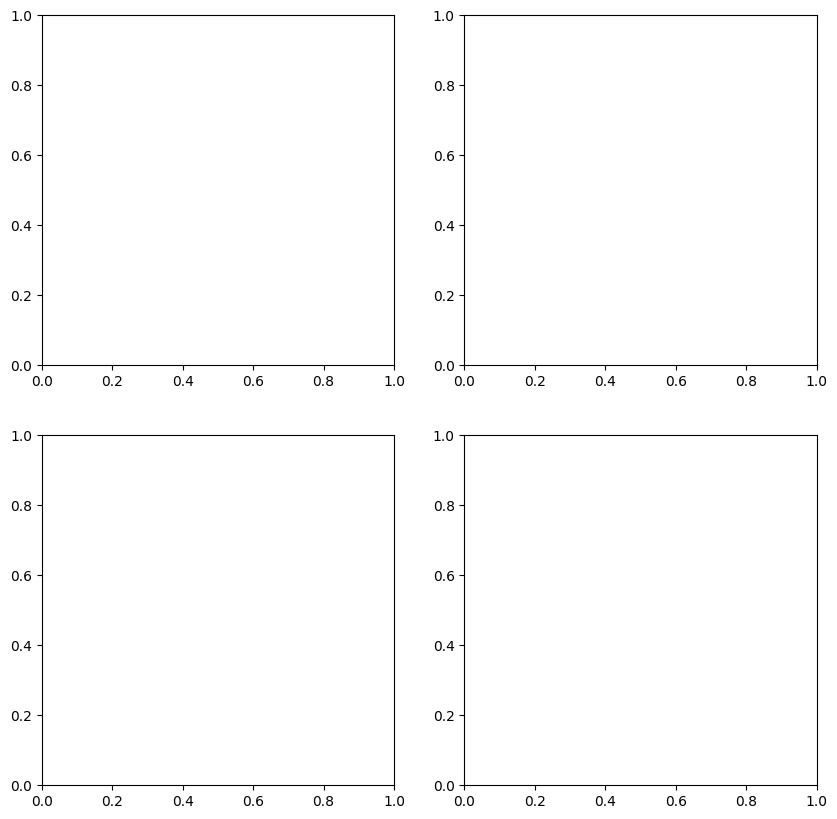

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import rasterio.plot as plot
import numpy as np

# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(2,2,figsize = (10,10))

# Convert ee.Image to numpy array before plotting
#rgb_array = np.array(clip_s2_comp.select(["B4","B3","B2"]).to_numpy())
#plot.show(rgb_array / 0.3,ax = ax[0,0],title = "RGB") # Normalize RGB values

# plot.show(idx.select("NDVI"),ax = ax[0,1],title = "NDVI")
# plot.show(idx.sel(index = "GNDVI").data,ax = ax[1,0],title = "GNDVI")
# plot.show(idx.sel(index = "SAVI").data,ax = ax[1,1],title = "SAVI")

# Convert the ee.Image to a NumPy array
ndvi_array = np.array(idx.select("NDVI").to_numpy()) # Convert ee.Image to NumPy array
plot.show(ndvi_array, ax=ax[0,1], title="NDVI") # Plot the NDVI array


AttributeError: 'numpy.ndarray' object has no attribute 'sel'

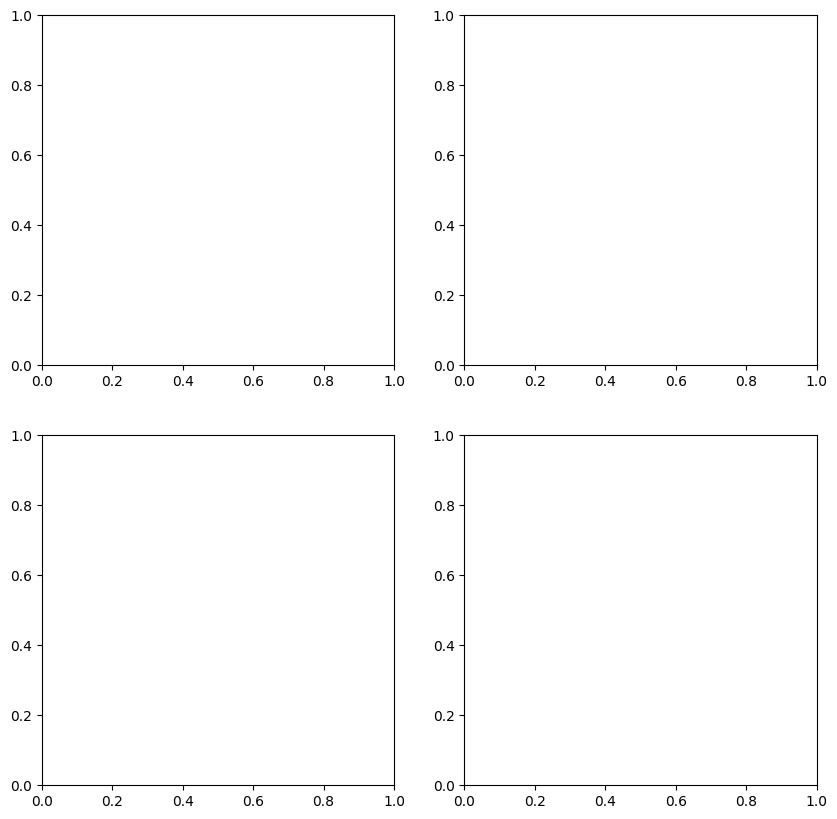

In [ ]:
# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(2,2,figsize = (10,10))
#plot.show(tp_array[:,:,0:2] / 0.3,ax = ax[0,0],title = "RGB")
plot.show(idx.sel(index = "NDVI").data,ax = ax[0,1],title = "NDVI")
plot.show(idx.sel(index = "GNDVI").data,ax = ax[1,0],title = "GNDVI")
plot.show(idx.sel(index = "SAVI").data,ax = ax[1,1],title = "SAVI")

In [ ]:
# prompt: tem como transformar o arquivo clip_s2_comp em array

import numpy as np

# Convert the image to a NumPy array
array = clip_s2_comp.array()

# Print the shape of the array
print(array.shape)


In [ ]:
# Convert the image to a NumPy array
array = clip_s2_comp.array()

# Print the shape of the array
print(array.shape)

AttributeError: 'Image' object has no attribute 'array'

In [ ]:
parameters = {
    "kNN": 1.0,
    "kNR": spyndex.computeKernel(
        kernel = "RBF",
        params = {
            "a": clip_s2_comp.select("B8"),
            "b": clip_s2_comp.select("B4"),
            "sigma": clip_s2_comp.select(["B8","B4"]).reduceRegion(  # Calculate sigma and convert to ee.Image
                reducer=ee.Reducer.mean(),
                geometry=ROI,
                scale=30
            ).toImage()  # Convert the dictionary to an ee.Image
        }
    )
}

In [ ]:
kNDVI = spyndex.computeIndex("kNDVI", parameters)
kNDVI

TypeError: Image data of dtype object cannot be converted to float

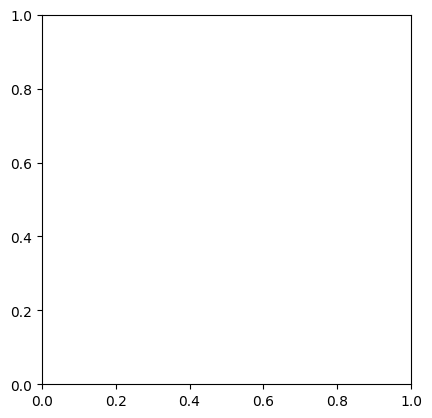

In [ ]:
plot.show(kNDVI,title = "kNDVI")

##Referências
- Index DataBase: https://www.indexdatabase.de

